<a href="https://colab.research.google.com/github/Dannynis/Acoustic-Scene-Classification-and-Time-of-Day-Estimation/blob/main/sympyPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install -U torch==2.3.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
from sympy.polys.specialpolys import random_poly
from sympy.abc import x
from random import randint
import sympy as sp

import torch
import tqdm

import numpy as np

n = randint(1,5)
p = random_poly(x,n,-9,9)
# p.evalf(subs = {x:10})

In [3]:
numpy_func = sp.lambdify(x,p, modules='numpy')

In [4]:
input_x = np.linspace(-10,10,1000)#np.random.rand(10000)

In [5]:
output_y = numpy_func(input_x)

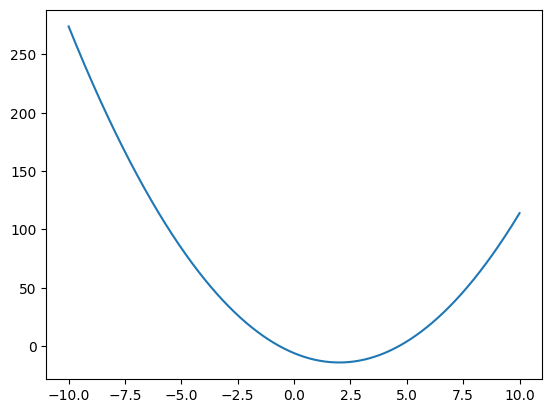

In [6]:
import matplotlib.pyplot as plt
plt.plot(input_x,output_y)

In [7]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


In [30]:
vocab =  [str(x) for x in list(range(10))] + ['^','x','+','-','*']
def tokenize(p):
  total_exp = []
  math_exp = str(p).replace('**','^')
  for att in math_exp.split():
    for c in att:
      if vocab.index(c) ==0 :
        print(p)
        raise
      total_exp.append(vocab.index(c))
  return total_exp

def pad_exp(x):
  start = torch.tensor([len(vocab)+1])
  end = torch.tensor([len(vocab)+2])
  x = torch.tensor(x)
  x = torch.cat((start,x,end))
  if len(x) > 64:
    raise
  return nn.functional.pad(x,(0,64-len(x)))


data = []
for i in tqdm.tqdm(range(100000)):
    n = randint(0,5)
    p = random_poly(x,n,-9,9)
    if n ==0 :
      output_y = int(p) + input_x*0
    else:
      numpy_func = sp.lambdify(x,p, modules='numpy')
      output_y = numpy_func(input_x)
    toknized_exp = pad_exp(tokenize(str(p)))
    data.append((output_y,toknized_exp))

100%|██████████| 100000/100000 [03:21<00:00, 496.53it/s]


In [31]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        #todo: why need cuda ????
        self.pe = torch.zeros(max_len, d_model).cuda()
        self.position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        self.div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(self.position * self.div_term)
        self.pe[:, 1::2] = torch.cos(self.position * self.div_term)
        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

def create_padding_mask(seq):
    mask = (seq != 0)
    return mask

# Define the Transformer model
class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True), num_encoder_layers)
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True), num_decoder_layers)
        self.target_embedding = nn.Embedding(target_vocab_size, d_model)
        self.linear = nn.Linear(d_model, target_vocab_size)
        self.prenet = nn.Linear(1, d_model)
        self.positional_encode = PositionalEncoding(d_model,dropout)

    def forward(self, src, tgt):
      tgt_pad_mask = create_padding_mask(tgt)
      tgt = self.target_embedding(tgt)
      tgt = self.positional_encode(tgt)
      src = self.prenet(src.unsqueeze(-1).float())
      memory = self.encoder(src)
      output = self.decoder(tgt, memory,tgt_key_padding_mask = tgt_pad_mask)
      output = self.linear(output)
      return output

# Define hyperparameters
target_vocab_size = len(vocab) + 3  # Add start, end, and padding tokens
d_model = 512
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
dropout = 0.1
batch_size = 16
num_epochs = 1000

# Create dataset and dataloader
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)


In [32]:
# positional_encode.pe.shape

In [33]:
# model.target_embedding(tgt).shape

In [34]:
# positional_encode(src.unsqueeze(-1).transpose(0,1))

In [13]:
# batch = next(iter(dataloader))
# src = batch[0]
# tgt = batch[1]

In [14]:
model = Transformer(1, target_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)


In [15]:
# self = model

In [16]:
# data[0]

In [17]:
# src = batch[0]
# tgt = batch[1]

In [18]:
# tgt_pad_mask

In [19]:
# tgt_pad_mask = create_padding_mask(tgt)
# tgt = self.target_embedding(tgt)
# src = self.prenet(src.unsqueeze(-1).float())
# memory = self.encoder(src)
# output = self.decoder(tgt, memory,tgt_key_padding_mask = tgt_pad_mask)
# output = self.linear(output)

In [ ]:
device = 'cuda'
# Instantiate the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

# Training loop
# with torch.autograd.set_detect_anomaly(True):
from torch.nn.attention import SDPBackend, sdpa_kernel

with sdpa_kernel(SDPBackend.MATH):
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, batch in tqdm.tqdm(enumerate(dataloader),total=len(dataloader)):
          inputs, targets = batch
          inputs = inputs.to(device)
          targets = targets.to(device)
          optimizer.zero_grad()
          outputs = model(inputs, targets[:, :-1])  # Exclude the last target token
          loss = criterion(outputs.transpose(1, 2), targets[:, 1:])  # Exclude the first target token
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          if i % 100 == 0:
              print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item()}")
      torch.save(model.state_dict(), f"/content/drive/MyDrive/sympyPred/model_{epoch+1}.pt")
      print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

  0%|          | 1/6250 [00:01<1:51:27,  1.07s/it]

Epoch 1, Batch 1, Loss: 0.10271698236465454


  2%|▏         | 101/6250 [01:44<1:49:44,  1.07s/it]

Epoch 1, Batch 101, Loss: 0.12643322348594666


  2%|▏         | 142/6250 [02:29<1:50:53,  1.09s/it]

In [ ]:
outputs.argmax(-1)[0]

In [ ]:
len(vocab)

In [ ]:
targets[0]

In [ ]:
outouts[0]

In [22]:
def detokenize(tokens, vocab):
    res = []
    if tokens[0] == 16:
        tokens = tokens[1:]
    tokens = tokens[:(tokens == 0).nonzero(as_tuple=True)[0][0]]
    for token in tokens:
      if token != 17:
        res.append(vocab[token])
    return res

In [23]:
# (outputs.argmax(-1)[1] == 0).nonzero(as_tuple=True)[0][0]

In [24]:
# (targets[1] == 17).nonzero(as_tuple=True)

In [25]:
# detokenize(targets[1],vocab)

In [26]:
# targets[1]

In [27]:
# outputs.argmax(-1)[]

In [28]:
import sympy

In [ ]:
sympy.parsing.sympy_parser.parse_expr(''.join(detokenize(targets[i], vocab)).replace('^','**'))

In [29]:
for i in range(10):
  print(''.join(detokenize(targets[i], vocab)))
  print(''.join(detokenize(outputs.argmax(-1)[i], vocab)))
  print('##################################')

x-7
x-2
##################################
-7*x^5-8*x^4-3*x^3-4*x^2-7*x+6
-6*x^5-6*x^4-6*x^3+8*x^2-8*x+2
##################################
5*x^2-6*x-5
x*x^2-8*x-5
##################################
-9*x^5-9*x^4-8*x^3-2*x^2-3*x+9
-6*x^5-9*x^4-5*x^3+8*x^2-8*x+9
##################################
-6*x^2+7*x+6
-6*x^2-8*x+2
##################################
5*x^3+6*x^2-2*x
-*x^3+8*x^2-x*x
##################################
3*x^4+7*x^3-6*x^2-8*x-4
x*x^4-8*x^3-9*x^2-8*x-9
##################################
-9
-8
##################################


IndexError: index 8 is out of bounds for dimension 0 with size 8

In [ ]:
outputs[-1].argmax(-1)

In [ ]:
vocab